# Evaluation of the TFI-signal

# Libraries

In [9]:
import os
import pandas as pd
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import tukey_hsd
import matplotlib.pyplot as plt
import pingouin as pg
from pingouin import ancova
from matplotlib.patches import Patch
#import statannotations as sa
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
import xlsxwriter
import lxml

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from datetime import datetime
from scipy.signal import correlate

# Directories


In [10]:
ROOT = Path().resolve().parent      # one level up from current dir
visual_stimulation_df = pd.read_excel(ROOT / "data/Visual_stimulation/flicker_results.xlsx")
visual_stimulation_timecourse_df = pd.read_csv(ROOT / "data/Visual_stimulation/all_timeseries.csv")
visual_stimulation_timecourse_rest_df = pd.read_csv(ROOT / "data/Visual_stimulation/all_timeseries_rest.csv") # As end of CSF was reached in first timecourse file
sleep_df = pd.read_excel(ROOT / "data/Sleep/sleep_results.xlsx")
sleep_timecourse_df = pd.read_csv(ROOT / "data/Sleep/all_timeseries_sleep_Fig_4.csv")
wake_timecourse_df = pd.read_csv(ROOT / "data/Sleep/all_timeseries_wake_Fig_4.csv")

# Edit the RC file

In [11]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "svg.fonttype": "none"
})

# Set Tick Size

In [12]:
sns.set(rc={'axes.linewidth': 2.0})
sns.set_style("white")
sns.set_style("ticks")

# Prep the dataframes

In [13]:
flicker = visual_stimulation_df
flicker_timecourse = visual_stimulation_timecourse_df
flicker_timecourse_rest = visual_stimulation_timecourse_rest_df
sleep = sleep_df
sleep_timecourse = sleep_timecourse_df
wake_timecourse = wake_timecourse_df   

# Visual stimulation

# Panel 4B

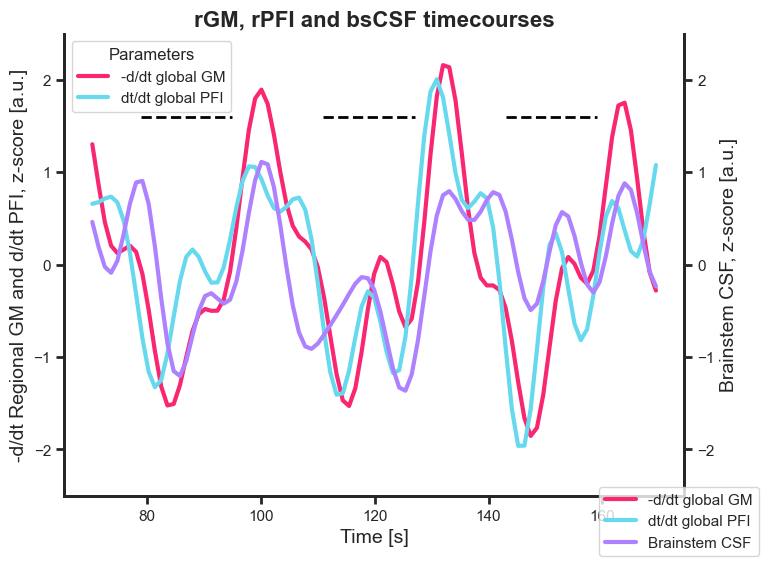

In [14]:
# Create the single subject timecourse
monokai_pro_palette_tc_1 = [
    (249, 38, 114),   # Red
    (102, 217, 239),  # Blue

]
# Convert RGB values to a format Seaborn understands (scaled between 0 and 1)
monokai_pro_palette_tc_1 = [(r / 255, g / 255, b / 255) for r, g, b in monokai_pro_palette_tc_1]

# Select columns that start with "gm_tc"
gm_tc_columns = [col for col in flicker_timecourse.columns if col.startswith("occipital_gm_derivative")]
pfi_tc_columns = [col for col in flicker_timecourse.columns if col.startswith("posterior_pfi_derivative")]
csf_tc_columns = [col for col in flicker_timecourse_rest.columns if col.startswith("csf")]

# Specify the index of the subject you are interested in
subject_row = flicker_timecourse[flicker_timecourse['subID'] == 'sub-15-3']
subject_index = subject_row.index[0]  # Change this to the specific row index of your subject

# Extract the timecourses for the specific subject
timecourses_gm = flicker_timecourse.loc[subject_index, gm_tc_columns].values.tolist()
timecourses_gm = stats.zscore(timecourses_gm)
timecourses_gm = -timecourses_gm
timecourses_gm_df = pd.DataFrame({'tc': timecourses_gm})


# Extract the timecourses for the specific subject
timecourses_pfi = flicker_timecourse.loc[subject_index, pfi_tc_columns].values.tolist()
timecourses_pfi = stats.zscore(timecourses_pfi)
timecourses_pfi_df = pd.DataFrame({'tc': timecourses_pfi})

# Extract the timecourses for the specific subject
timecourses_csf = flicker_timecourse_rest.loc[subject_index, csf_tc_columns].values.tolist()
timecourses_csf = stats.zscore(timecourses_csf)
timecourses_csf_df = pd.DataFrame({'tc': timecourses_csf})

# Generate the ranges
range_gm = range(1, len(timecourses_gm) + 1)
range_pfi = range(1, len(timecourses_pfi) + 1)
range_csf = range(1, len(timecourses_csf) + 1)

# Convert ranges to Series for concatenation
range_gm_series = pd.Series(range_gm)
range_pfi_series = pd.Series(range_pfi)
range_csf_series = pd.Series(range_csf)

Subject = pd.DataFrame()
Subject_csf = pd.DataFrame()

# Create a new DataFrame with a single column for the specific subject's timecourses
Subject['tc'] = pd.concat([timecourses_gm_df, timecourses_pfi_df], axis=0).reset_index(drop=True)
Subject['timepoints'] = pd.concat([range_gm_series, range_pfi_series], axis=0).reset_index(drop=True)
Subject['timepoints'] = (Subject['timepoints'] * 1.1) + 5 * 1.1 # See if I need to do this!
Subject_categorical = [0] * len(timecourses_gm_df) + [1] * len(timecourses_pfi_df)
Subject['variables_categorical'] = Subject_categorical
Subject['Parameters'] = Subject['variables_categorical'].apply(lambda x: "-d/dt global GM" if x == 0  else "dt/dt global PFI")


# Create a new DataFrame with a single column for the specific subject's timecourses
Subject_csf['tc'] = timecourses_csf_df
Subject_csf['timepoints'] = range_csf_series
Subject_csf['timepoints'] = (Subject_csf['timepoints'] * 1.1) + 5 * 1.1 # See if I need to do this!



# Display the new DataFrame
#print(Subject)
Subject_short = Subject[(Subject['timepoints'] >= 70) & (Subject['timepoints'] <= 170)]
Subject_short_csf = Subject_csf[(Subject_csf['timepoints'] >= 70) & (Subject_csf['timepoints'] <= 170)]

fig,ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()  # Create secondary y-axis

sns.lineplot(x="timepoints", y='tc', data=Subject_short, ax=ax1, hue='Parameters', palette=monokai_pro_palette_tc_1, linewidth=3, legend=True)
sns.lineplot(x="timepoints", y='tc', data=Subject_short_csf, ax=ax2, label='Brainstem CSF', color=(174/255, 129/255, 255/255), linewidth=3, legend=False)



# Set labels
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('-d/dt Regional GM and d/dt PFI, z-score [a.u.]', fontsize=14)
ax2.set_ylabel('Brainstem CSF, z-score [a.u.]', fontsize=14)

# Adjust ticks
ax1.tick_params(axis='y')
ax1.set_ylim(-2.5,2.5)
ax2.set_ylim(-2.5,2.5)
ax2.tick_params(axis='y')

plt.title(f'rGM, rPFI and bsCSF timecourses',fontsize = 16, weight = 'bold')
ax1.tick_params(axis='x', which='both', direction='out', width=2)
ax1.tick_params(axis='y', which='both', direction='out', width=2)
ax2.tick_params(axis='x', which='both', direction='out', width=2)
ax2.tick_params(axis='y', which='both', direction='out', width=2)

highlight_y = 1.6  # Choose a y-position that doesn't overlap key data

for start_time in [79, 111, 143]:
    ax1.hlines(y=highlight_y, xmin=start_time, xmax=start_time + 16, 
               colors='black', linestyles='dashed', linewidth=2)

fig.legend(loc='lower right')
sns.despine(right=False, left=False)



# Save the figure -------
#image_path = os.path.join(outDir, f'Flicker_timecourse_2.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Flicker_timecourse_2.svg')
#fig.savefig(image_path_svg)

# Panel 4C - left

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
-2.2
0.2991653434005866


Text(0.6, 0.2, 'Rmax lag = -2.2s')

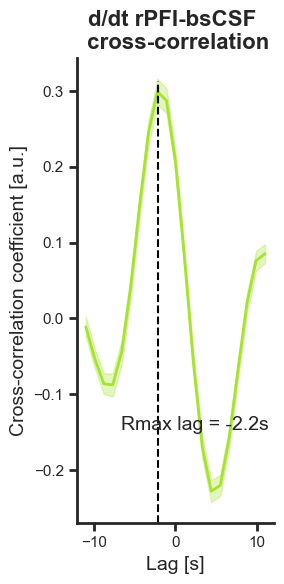

In [15]:
#Plot new
lag_numbers = [int(col.split('_')[-1]) for col in flicker.columns if col.startswith('xcorr_posterior_ventricle_csf_')]
lag_numbers.sort()  # Sort lag numbers in ascending order
print(lag_numbers)
# Calculate mean and standard error of the mean (SEM) across all subjects for each time lag
mean_values = flicker[[f'xcorr_posterior_ventricle_csf_{lag}' for lag in lag_numbers]].mean(axis=0)
sem_values = flicker[[f'xcorr_posterior_ventricle_csf_{lag}' for lag in lag_numbers]].sem(axis=0)

# Convert to arrays for plotting
time_lags = lag_numbers
time_lags_plot = np.arange(-10, 11)
time_lags_plot = time_lags_plot * 1.1
mean_values_array = mean_values.values
sem_values_array = sem_values.values

max_y_index = np.argmax(mean_values_array)
max_y = mean_values_array[max_y_index]
max_x = time_lags_plot[max_y_index]

print(max_x)
print(max_y)
fig = plt.figure(figsize=(3, 6))

# Plot the mean line with error bars
xcorr_mean = sns.lineplot(x=time_lags_plot, y=mean_values_array, color=(166/255, 226/255, 46/255), linewidth=2)
xcorr_mean.fill_between(time_lags_plot,mean_values_array-sem_values_array,mean_values_array+sem_values_array, color=(166/255, 226/255, 46/255), alpha=0.3)
xcorr_mean.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
xcorr_mean.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed

# Annotate the maximum value with its x and y values
#axes[0].annotate(f'Min: ({max_x:.2f}, {max_y:.2f})', xy=(max_x, max_y), xytext=(max_x + 1, max_y), arrowprops=dict(facecolor='black', arrowstyle='->'))
xcorr_mean.axvline(x=max_x, linestyle='--', color='black', linewidth=1.5, ymax=0.95)

plt.title(f"d/dt rPFI-bsCSF \n cross-correlation",fontsize = 16,weight='bold', loc='center')
plt.xlabel('Lag [s]', fontsize = 14)
plt.ylabel('Cross-correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()

plt.text(0.6, 0.2, f"Rmax lag = {max_x:.1f}s", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Flicker_cross_corr_2_new.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Flicker_cross_corr_2_new.svg')
#fig.savefig(image_path_svg)

# Panel 4C - right

Mean: 0.322, Standard Deviation: 0.177
t-statistic: 18.66591946237769
p-value: 3.9140126656385715e-35


Text(0.5, 0.97, '****')

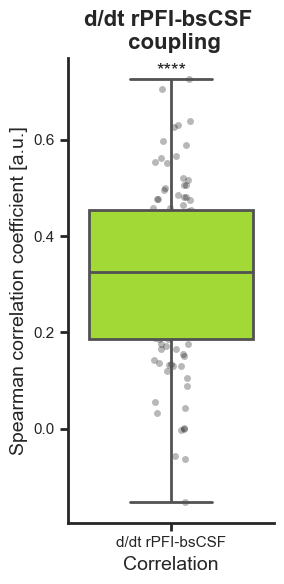

In [16]:
# Plot new
flicker['pair_name'] = "d/dt rPFI-bsCSF"
fig = plt.figure(figsize=(3, 6))


ax = sns.stripplot(data=flicker, x="pair_name", y="r_posterior_ventricle_csf",color='black', dodge=True, alpha=0.28, zorder = 0)#(102/255, 217/255, 239/255), 0.9764705882352941, 0.14901960784313725, 0.4470588235294118
stripplot = sns.boxplot(data=flicker, x="pair_name", y="r_posterior_ventricle_csf",saturation=0.9, linewidth=2,flierprops=dict(marker='o', markersize=3), color=(166/255, 226/255, 46/255), showfliers=False)#, medianprops={'color':(102/255, 217/255, 239/255)})


ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
plt.title(f"d/dt rPFI-bsCSF \n coupling",fontsize = 16, weight = 'bold')
plt.xlabel('Correlation', fontsize = 14)
plt.ylabel('Spearman correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()  # Adjust spines

mean_val = flicker['r_posterior_ventricle_csf'].mean()
std_val = flicker['r_posterior_ventricle_csf'].std()

print(f"Mean: {mean_val:.3f}, Standard Deviation: {std_val:.3f}")

# statistic whether it is different to zero
data = flicker['r_posterior_ventricle_csf']
#print(data)

# Perform the one-sample t-test
t_statistic, p_value = stats.ttest_1samp(data, 0, nan_policy='omit')

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Annotate the plot with the t-test result
# Format p-value
if p_value < 0.0001:
    p_str = '****'
else:
    p_str = f'p = {p_value:.3f}'

# Add the calculated p-value as custom text on the plot
plt.text(0.5, 0.97, f"{p_str}", ha='center', va='center', transform=ax.transAxes, fontsize=14)
#test_results = add_stat_annotation(ax, data=flicker, x="pair_name", y="r_ventricle_gm", box_pairs=[("pair_name", "r_ventricle_gm")], test='t-test_ind', text_format='star', loc='inside', verbose=2)

# Save the figure -------
#image_path = os.path.join(outDir, f'Flicker_boxplot_2_new.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Flicker_boxplot_2_new.svg')
#fig.savefig(image_path_svg)

# Prep the light sleep and wakefulness dataframes

In [ ]:
# First of all we test for amplitude difference, with a repeated measure anova

sleep_anova = sleep.drop(['session', 'start_time', 'session_number', 'Start_TR', 'End_TR'], axis=1)

# drop rows, where sleep stadium wasn't properly assigned
sleep_anova_drop = sleep_anova.loc[sleep_anova['sleep_stage'].isin(['1', '2'])]
wake_anova_drop = sleep_anova.loc[sleep_anova['sleep_stage'].isin(['0'])]

sleep_anova_drop['sleep_stage'] = sleep_anova_drop['sleep_stage'].astype(int)
wake_anova_drop['sleep_stage'] = wake_anova_drop['sleep_stage'].astype(int)

# Code sleep stage as categorical variable, so it is not numeric and thus handled categorically rather than calculating linear increase in amplitude, when sleep stage jumps 1 higher
sleep_anova_drop['sleep_stage_letter'] = sleep_anova_drop['sleep_stage'].apply(lambda x: 'a' if x == 1 else ('b' if x == 2 else 'c'))
sleep_anova_drop['partial_volume_amplitude'] = sleep_anova_drop['partial_volume_amplitude'].astype(int)


wake_anova_drop['sleep_stage_letter'] = wake_anova_drop['sleep_stage'].apply(lambda x: 'a' if x == 0 else None)
wake_anova_drop['partial_volume_amplitude'] = wake_anova_drop['partial_volume_amplitude'].astype(int)


# Extract numerical part from 'subID' column
sleep_anova_drop['subID_cat'] = sleep_anova_drop['subID'].str.extract(r'(\d+)')
wake_anova_drop['subID_cat'] = wake_anova_drop['subID'].str.extract(r'(\d+)')
# Convert 'subID_cat' column to numeric type
sleep_anova_drop['subID_cat'] = pd.to_numeric(sleep_anova_drop['subID_cat'])
wake_anova_drop['subID_cat'] = pd.to_numeric(wake_anova_drop['subID_cat'])


/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5869/2253546225.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_anova_drop['sleep_stage'] = sleep_anova_drop['sleep_stage'].astype(int)
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5869/2253546225.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wake_anova_drop['sleep_stage'] = wake_anova_drop['sleep_stage'].astype(int)
/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5869/2253546225.py:13: SettingWithCopyWarnin

# Light sleep


# Panel 4E

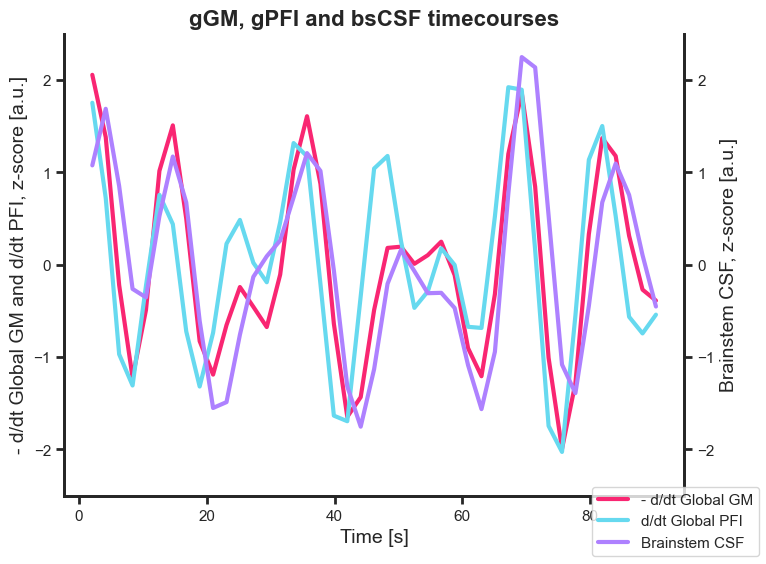

In [24]:

subject_of_choice = 41 



sleep_timecourse_dataframe = pd.DataFrame()
# Filter the dataframe for the chosen subject
sleep_timecourse_dataframe = sleep_timecourse.iloc[[subject_of_choice]]


# Select columns that start with "gm_tc"
gm_tc_columns = [col for col in sleep_timecourse_dataframe.columns if col.startswith("gm_derivative")]
pfi_tc_columns = [col for col in sleep_timecourse_dataframe.columns if col.startswith("pfi_derivative")]
csf_tc_columns = [col for col in sleep_timecourse_dataframe.columns if col.startswith("csf_tc")]

#print(len(gm_tc_columns))
# Concatenate the selected columns along axis=0 (stacking them)
gm_values = pd.concat([sleep_timecourse_dataframe[col] for col in gm_tc_columns], axis=0).reset_index(drop=True)

gm_values= stats.zscore(gm_values)
pfi_values = pd.concat([sleep_timecourse_dataframe[col] for col in pfi_tc_columns], axis=0).reset_index(drop=True)

pfi_values= stats.zscore(pfi_values)
csf_values = pd.concat([sleep_timecourse_dataframe[col] for col in csf_tc_columns], axis=0).reset_index(drop=True)

csf_values= stats.zscore(csf_values)

sleep_timecourse_new_two = pd.DataFrame()
sleep_timecourse_new_two['timepoints'] = (pd.Series(range(1, len(gm_values) + 1))) * 2.1 # This is the wake/sleep TR
sleep_timecourse_new_two['global_gm'] = -gm_values
sleep_timecourse_new_two['global_pfi'] = pfi_values
sleep_timecourse_new_two['brainstem_csf'] = csf_values

fig,ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()  # Create secondary y-axis

sns.lineplot(x="timepoints", y='global_gm', data=sleep_timecourse_new_two, ax=ax1, label='- d/dt Global GM', color=(249/255, 38/255, 114/255), linewidth=3, legend=False)
sns.lineplot(x="timepoints", y='global_pfi', data=sleep_timecourse_new_two, ax=ax1, label='d/dt Global PFI', color=(102/255, 217/255, 239/255), linewidth=3, legend=False)
sns.lineplot(x="timepoints", y='brainstem_csf', data=sleep_timecourse_new_two, ax=ax2, label='Brainstem CSF', color=(174/255, 129/255, 255/255), linewidth=3, legend=False)



# Set labels
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('- d/dt Global GM and d/dt PFI, z-score [a.u.]', fontsize=14)
ax2.set_ylabel('Brainstem CSF, z-score [a.u.]', fontsize=14)

# Adjust ticks
ax1.tick_params(axis='y')
ax1.set_ylim(-2.5,2.5)
ax2.set_ylim(-2.5,2.5)
ax2.tick_params(axis='y')

plt.title(f'gGM, gPFI and bsCSF timecourses',fontsize = 16, weight = 'bold')
ax1.tick_params(axis='x', which='both', direction='out', width=2)
ax1.tick_params(axis='y', which='both', direction='out', width=2)
ax2.tick_params(axis='x', which='both', direction='out', width=2)
ax2.tick_params(axis='y', which='both', direction='out', width=2)

fig.legend(loc='lower right')
sns.despine(right=False, left=False)



# Save the figure -------
#image_path = os.path.join(outDir, f'Sleep_timecourse_2_chunks.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Sleep_timecourse_2_chunks.svg')
#fig.savefig(image_path_svg)

# Panel 4F - left

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
-2.1


Text(0.6, 0.2, 'Rmax lag = -2.1s')

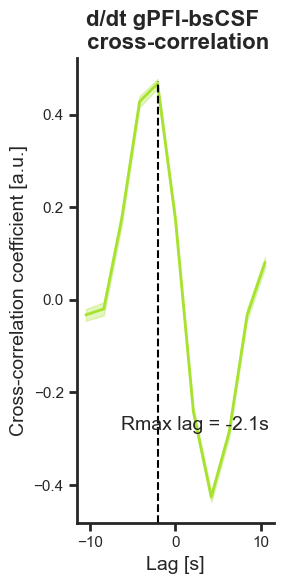

In [ ]:

#Plot new
lag_numbers = [int(col.split('_')[-1]) for col in sleep_anova_drop.columns if col.startswith('xcorr_ventricle_csf_')]
lag_numbers.sort()  # Sort lag numbers in ascending order
print(lag_numbers)
# Calculate mean and standard error of the mean (SEM) across all subjects for each time lag
mean_values = sleep_anova_drop[[f'xcorr_ventricle_csf_{lag}' for lag in lag_numbers]].mean(axis=0)
sem_values = sleep_anova_drop[[f'xcorr_ventricle_csf_{lag}' for lag in lag_numbers]].sem(axis=0)

# Convert to arrays for plotting
time_lags = lag_numbers
time_lags_plot = np.arange(-10, 11)
time_lags_plot = time_lags_plot * 2.1 # This is the sleep TR
mean_values_array = mean_values.values
sem_values_array = sem_values.values

max_y_index = np.argmax(mean_values_array)
max_y = mean_values_array[max_y_index]
max_x = time_lags_plot[max_y_index]
print(max_x)

#Adjust so they only show the -10 - 10s mark
time_lags_plot = time_lags_plot[5:-5] # This is the sleep TR
mean_values_array = mean_values_array[5:-5]
sem_values_array = sem_values_array[5:-5]

fig = plt.figure(figsize=(3, 6))

# Plot the mean line with error bars
xcorr_mean = sns.lineplot(x=time_lags_plot, y=mean_values_array, color=(166/255, 226/255, 46/255), linewidth=2)
xcorr_mean.fill_between(time_lags_plot,mean_values_array-sem_values_array,mean_values_array+sem_values_array, color=(166/255, 226/255, 46/255), alpha=0.3)
xcorr_mean.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
xcorr_mean.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed


xcorr_mean.axvline(x=max_x, linestyle='--', color='black', linewidth=1.5, ymax=0.95)

plt.title(f"d/dt gPFI-bsCSF \n cross-correlation",fontsize = 16,weight='bold', loc='center')
plt.xlabel('Lag [s]', fontsize = 14)
plt.ylabel('Cross-correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()

plt.text(0.6, 0.2, f"Rmax lag = {max_x:.1f}s", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Sleep_cross_corr_2_new.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Sleep_cross_corr_2_new.svg')
#fig.savefig(image_path_svg)



# Panel 4F - right

Mean: 0.460, Standard Deviation: 0.203
t-statistic: 43.152639967843925
p-value: 1.4564879151834156e-144


/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5869/3107155702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_anova_drop['pair_name'] = "d/dt gPFI-bsCSF"


Text(0.5, 0.97, '****')

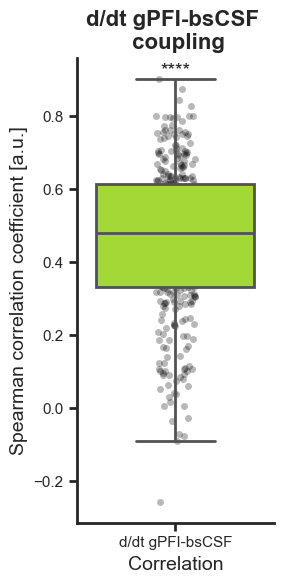

In [26]:

# Plot new
sleep_anova_drop['pair_name'] = "d/dt gPFI-bsCSF"
fig = plt.figure(figsize=(3, 6))


ax = sns.stripplot(data=sleep_anova_drop, x="pair_name", y="r_ventricle_csf",color='black', dodge=True, alpha=0.28, zorder = 0)#(102/255, 217/255, 239/255), 0.9764705882352941, 0.14901960784313725, 0.4470588235294118
stripplot = sns.boxplot(data=sleep_anova_drop, x="pair_name", y="r_ventricle_csf",saturation=0.9, linewidth=2,flierprops=dict(marker='o', markersize=3), color=(166/255, 226/255, 46/255), showfliers=False)#, medianprops={'color':(102/255, 217/255, 239/255)})


ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
plt.title(f"d/dt gPFI-bsCSF \n coupling",fontsize = 16, weight = 'bold')
plt.xlabel('Correlation', fontsize = 14)
plt.ylabel('Spearman correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()  # Adjust spines



# statistic whether it is different to zero
data = sleep_anova_drop['r_ventricle_csf']
#print(data)
mean_val = sleep_anova_drop['r_ventricle_csf'].mean()
std_val = sleep_anova_drop['r_ventricle_csf'].std()

print(f"Mean: {mean_val:.3f}, Standard Deviation: {std_val:.3f}")
# Perform the one-sample t-test
t_statistic, p_value = stats.ttest_1samp(data, 0, nan_policy='omit')
# Perform the one-sample t-test
t_statistic, p_value = stats.ttest_1samp(data, 0, nan_policy='omit')

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Annotate the plot with the t-test result
# Format p-value
if p_value < 0.0001:
    p_str = '****'
else:
    p_str = f'p = {p_value:.3f}'

# Add the calculated p-value as custom text on the plot
plt.text(0.5, 0.97, f"{p_str}", ha='center', va='center', transform=ax.transAxes, fontsize=14)


# Save the figure -------
#image_path = os.path.join(outDir, f'Sleep_boxplot_2_new.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Sleep_boxplot_2_new.svg')
#fig.savefig(image_path_svg)

# Wakefulness

# Panel 4H

     subID  gm_derivative_tc_1  gm_derivative_tc_2  gm_derivative_tc_3  \
82  sub-09           12.466845            7.125234           -3.228871   

    gm_derivative_tc_4  gm_derivative_tc_5  gm_derivative_tc_6  \
82           -8.880927           -6.784372           -1.384315   

    gm_derivative_tc_7  gm_derivative_tc_8  gm_derivative_tc_9  ...  \
82             2.13708            2.575434            1.111465  ...   

      csf_tc_34   csf_tc_35    csf_tc_36   csf_tc_37   csf_tc_38    csf_tc_39  \
82 -1757.630533  879.769018  2137.376774  834.231947 -1090.39743 -1369.761089   

     csf_tc_40   csf_tc_41  csf_tc_42   csf_tc_43  
82 -222.064315  425.088229 -170.98313 -668.935879  

[1 rows x 216 columns]


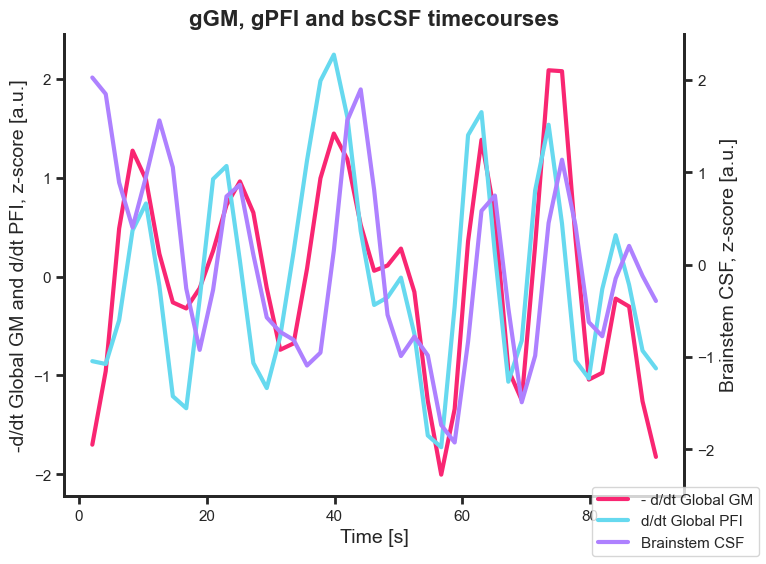

In [27]:
subject_of_choice = 82


wake_timecourse_dataframe = pd.DataFrame()
# Filter the dataframe for the chosen subject
wake_timecourse_dataframe = wake_timecourse.iloc[[subject_of_choice]]
print(wake_timecourse_dataframe)


# Select columns 
gm_tc_columns = [col for col in wake_timecourse_dataframe.columns if col.startswith("gm_derivative")]
pfi_tc_columns = [col for col in wake_timecourse_dataframe.columns if col.startswith("pfi_derivative")]
csf_tc_columns = [col for col in wake_timecourse_dataframe.columns if col.startswith("csf_tc")]


# Concatenate the selected columns along axis=0 (stacking them)
gm_values = pd.concat([wake_timecourse_dataframe[col] for col in gm_tc_columns], axis=0).reset_index(drop=True)

gm_values= stats.zscore(gm_values)
pfi_values = pd.concat([wake_timecourse_dataframe[col] for col in pfi_tc_columns], axis=0).reset_index(drop=True)

pfi_values= stats.zscore(pfi_values)
csf_values = pd.concat([wake_timecourse_dataframe[col] for col in csf_tc_columns], axis=0).reset_index(drop=True)

csf_values= stats.zscore(csf_values)



wake_timecourse_new_two = pd.DataFrame()
wake_timecourse_new_two['timepoints'] = (pd.Series(range(1, len(gm_values) + 1))) * 2.1 # This is the wake/sleep TR
wake_timecourse_new_two['global_gm'] = -gm_values
wake_timecourse_new_two['global_pfi'] = pfi_values
wake_timecourse_new_two['brainstem_csf'] = csf_values

fig,ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()  # Create secondary y-axis

sns.lineplot(x="timepoints", y='global_gm', data=wake_timecourse_new_two, ax=ax1, label='- d/dt Global GM', color=(249/255, 38/255, 114/255), linewidth=3, legend=False)
sns.lineplot(x="timepoints", y='global_pfi', data=wake_timecourse_new_two, ax=ax1, label='d/dt Global PFI', color=(102/255, 217/255, 239/255), linewidth=3, legend=False)
sns.lineplot(x="timepoints", y='brainstem_csf', data=wake_timecourse_new_two, ax=ax2, label='Brainstem CSF', color=(174/255, 129/255, 255/255), linewidth=3, legend=False)

# Flip ax1 values
#ax1.set_ylim(ax1.get_ylim()[::-1])

# Set labels
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('-d/dt Global GM and d/dt PFI, z-score [a.u.]', fontsize=14)
ax2.set_ylabel('Brainstem CSF, z-score [a.u.]', fontsize=14)

# Adjust ticks
ax1.tick_params(axis='y')
#ax1.set_ylim(-2.45,1.85)
ax2.set_ylim(-2.5,2.5)
ax2.tick_params(axis='y')

plt.title(f'gGM, gPFI and bsCSF timecourses',fontsize = 16, weight = 'bold')
ax1.tick_params(axis='x', which='both', direction='out', width=2)
ax1.tick_params(axis='y', which='both', direction='out', width=2)
ax2.tick_params(axis='x', which='both', direction='out', width=2)
ax2.tick_params(axis='y', which='both', direction='out', width=2)

fig.legend(loc='lower right')
sns.despine(right=False, left=False)



# Save the figure -------
#image_path = os.path.join(outDir, f'Wake_timecourse_2_chunks.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Wake_timecourse_2_chunks.svg')
#fig.savefig(image_path_svg)

# Panel 4I - left

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
-2.1


Text(0.6, 0.2, 'Rmax lag = -2.1s')

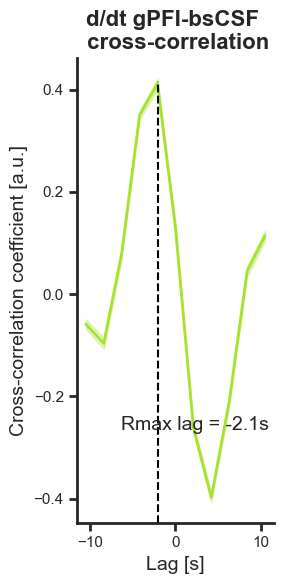

In [28]:
#Plot new
lag_numbers = [int(col.split('_')[-1]) for col in wake_anova_drop.columns if col.startswith('xcorr_ventricle_csf_')]
lag_numbers.sort()  # Sort lag numbers in ascending order
print(lag_numbers)
# Calculate mean and standard error of the mean (SEM) across all subjects for each time lag
mean_values = wake_anova_drop[[f'xcorr_ventricle_csf_{lag}' for lag in lag_numbers]].mean(axis=0)
sem_values = wake_anova_drop[[f'xcorr_ventricle_csf_{lag}' for lag in lag_numbers]].sem(axis=0)

# Convert to arrays for plotting
time_lags = lag_numbers
time_lags_plot = np.arange(-10, 11)
time_lags_plot = time_lags_plot * 2.1 # This is the sleep TR
mean_values_array = mean_values.values
sem_values_array = sem_values.values

max_y_index = np.argmax(mean_values_array)
max_y = mean_values_array[max_y_index]
max_x = time_lags_plot[max_y_index]
print(max_x)

#Adjust so they only show the -10 - 10s mark
time_lags_plot = time_lags_plot[5:-5] # This is the sleep TR
mean_values_array = mean_values_array[5:-5]
sem_values_array = sem_values_array[5:-5]

fig = plt.figure(figsize=(3, 6))

# Plot the mean line with error bars
xcorr_mean = sns.lineplot(x=time_lags_plot, y=mean_values_array, color=(166/255, 226/255, 46/255), linewidth=2)
xcorr_mean.fill_between(time_lags_plot,mean_values_array-sem_values_array,mean_values_array+sem_values_array, color=(166/255, 226/255, 46/255), alpha=0.3)
xcorr_mean.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
xcorr_mean.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed

# Annotate the maximum value with its x and y values
xcorr_mean.axvline(x=max_x, linestyle='--', color='black', linewidth=1.5, ymax=0.95)

plt.title(f"d/dt gPFI-bsCSF \n cross-correlation",fontsize = 16,weight='bold', loc='center')
plt.xlabel('Lag [s]', fontsize = 14)
plt.ylabel('Cross-correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()
#plt.xlim(-11,11)
plt.text(0.6, 0.2, f"Rmax lag = {max_x:.1f}s", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Wake_cross_corr_2_new.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Wake_cross_corr_2_new.svg')
#fig.savefig(image_path_svg)


# Panel 4I - right

Mean: 0.410, Standard Deviation: 0.225
t-statistic: 42.92784797567612
p-value: 3.408356606283181e-178


/var/folders/ml/8kb9cd2x2yz10lfbvzrvfxy40000gn/T/ipykernel_5869/2261858073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wake_anova_drop['pair_name'] = "d/dt gPFI-bsCSF"


Text(0.5, 0.97, '****')

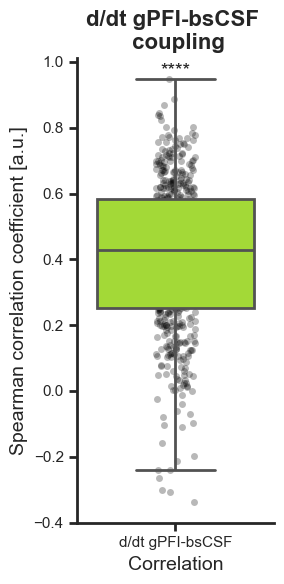

In [29]:
# Plot new
wake_anova_drop['pair_name'] = "d/dt gPFI-bsCSF"
fig = plt.figure(figsize=(3, 6))


ax = sns.stripplot(data=wake_anova_drop, x="pair_name", y="r_ventricle_csf",color='black', dodge=True, alpha=0.28, zorder = 0)#(102/255, 217/255, 239/255), 0.9764705882352941, 0.14901960784313725, 0.4470588235294118
stripplot = sns.boxplot(data=wake_anova_drop, x="pair_name", y="r_ventricle_csf",saturation=0.9, linewidth=2,flierprops=dict(marker='o', markersize=3), color=(166/255, 226/255, 46/255), showfliers=False)#, medianprops={'color':(102/255, 217/255, 239/255)})


ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
plt.title(f"d/dt gPFI-bsCSF \n coupling",fontsize = 16, weight = 'bold')
plt.xlabel('Correlation', fontsize = 14)
plt.ylabel('Spearman correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()  # Adjust spines



# statistic whether it is different to zero
data = wake_anova_drop['r_ventricle_csf']
#print(data)
mean_val = wake_anova_drop['r_ventricle_csf'].mean()
std_val = wake_anova_drop['r_ventricle_csf'].std()

print(f"Mean: {mean_val:.3f}, Standard Deviation: {std_val:.3f}")
# Perform the one-sample t-test
t_statistic, p_value = stats.ttest_1samp(data, 0, nan_policy='omit')

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Annotate the plot with the t-test result
# Format p-value
if p_value < 0.0001:
    p_str = '****'
else:
    p_str = f'p = {p_value:.3f}'

# Add the calculated p-value as custom text on the plot
plt.text(0.5, 0.97, f"{p_str}", ha='center', va='center', transform=ax.transAxes, fontsize=14)

#  Save the figure -------
#image_path = os.path.join(outDir, f'Wake_boxplot_2_new.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Wake_boxplot_2_new.svg')
#fig.savefig(image_path_svg)